In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import time
import sys
import itertools

# function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    #plt.xticks(xlocations, labels, rotation=90)
    #plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


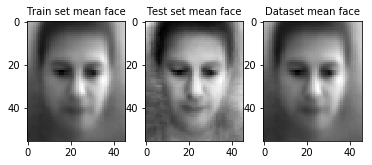

In [2]:
#-------------------data preprocessing----------------------------#
data = sio.loadmat('face.mat')
face_data=data['X']
c=data['l']
num_img = face_data.shape[1] # num_img=520
num_pix = face_data.shape[0]
# face_157 = face_data[:,157]
# face_157 = np.reshape(face_157,(46,56))
# face_157=face_157.T
# plt.imshow(face_157, cmap = 'gist_gray')
# split into train and test sets
img_idx_train = []
img_idx_test = []
for i in range(num_img):
    if i%10>8: #last 2 feed into test set
        img_idx_test.append(i)
    else:
        img_idx_train.append(i)
#training set
img_train = np.delete(face_data, img_idx_test, 1) # 2576*img_train.shape[1]
#test set
img_test = np.delete(face_data, img_idx_train, 1) # 2576*img_test.shape[1]
# average face vector for train set
img_mean = img_train.mean(axis=1)
img_mean_plt = np.reshape(img_mean,(46,56)).T
plt.subplot(1, 3, 1)
plt.imshow(img_mean_plt, cmap = 'gist_gray')
plt.title('Train set mean face', fontsize=10)

# average face vector for test set
img_mean_test = img_test.mean(axis=1)
img_mean_test_plt = np.reshape(img_mean_test,(46,56)).T
plt.subplot(1, 3, 2)
plt.imshow(img_mean_test_plt, cmap = 'gist_gray')
plt.title('Test set mean face', fontsize=10)

# average face vector for all data
img_mean_all = face_data.mean(axis=1)
img_mean_all_plt = np.reshape(img_mean_all,(46,56)).T
plt.subplot(1, 3, 3)
plt.imshow(img_mean_all_plt, cmap = 'gist_gray')
plt.title('Dataset mean face', fontsize=10)



img_norm = img_train - img_mean[:,None] # img_norm is 2576*img_train.shape[1]
# normalization
img_mean_test = img_test.mean(axis=1)
img_norm_test = img_test - img_mean_test[:,None] # img_norm_test is 2576*img_test.shape[1]

In [3]:
# ---------naive PCA-------------#
start_time = time.time()
S=np.divide(np.matmul(img_norm,img_norm.T),468)
print("memory occupied by S: %d" %sys.getsizeof(S))
eigvals, eigvecs = np.linalg.eig(S)
print("--- eigen decomposition %s seconds ---" %(time.time() - start_time))

# ---------fast PCA-------------#
start_time = time.time()
S_low=np.divide(np.matmul(img_norm.T,img_norm),468)
print("memory occupied by S_low: %d" %sys.getsizeof(S_low))
eigvals_low, eigvecs_low = np.linalg.eig(S_low)
print("--- lower dimension eigen decomposition %s seconds ---" %(time.time() - start_time))

memory occupied by S: 53086320
--- eigen decomposition 17.531054973602295 seconds ---
memory occupied by S_low: 1752304
--- lower dimension eigen decomposition 0.4374818801879883 seconds ---


In [7]:
eigvecs_pseudo = np.matmul(img_norm,eigvecs_low) # u is 2576 * 468 real
# Normalise computed u to 1
eigvecs_pseudo = preprocessing.normalize(eigvecs_pseudo, norm='l2', axis=0) # axis = 0, normalise each feature

In [8]:
eigvecs_pseudo

array([[ 0.01412656,  0.01180992, -0.01718239, ..., -0.01651393,
         0.0206831 ,  0.00172531],
       [ 0.0150236 ,  0.01203817, -0.01828044, ..., -0.00078086,
        -0.00349339,  0.02221179],
       [ 0.01582776,  0.0116198 , -0.02032426, ..., -0.01328496,
         0.04107948,  0.04407041],
       ...,
       [-0.00437069, -0.05059815,  0.00229628, ..., -0.02092093,
         0.02023878, -0.0305542 ],
       [-0.0042494 , -0.05083865,  0.00259694, ...,  0.00259927,
        -0.01179607,  0.00084961],
       [-0.00427415, -0.05125668,  0.00423394, ...,  0.0003571 ,
        -0.0079654 , -0.02089104]])

In [18]:
print(np.linalg.norm(eigvals-np.real(eigvals)))
# print(np.linalg.norm(eigvecs-np.real(eigvecs)))
# print(eigvals)
# print(eigvals_low)
print(np.count_nonzero(eigvals))
print(np.count_nonzero(eigvals > 1e-8))

1.0885538671469418e-10
2576
467


The matrix is full rank because there is non zero eigen_values

In [29]:
# -----sort eigenValues and eigenVectors--------#
eigvals.tolist()
idx = eigvals.argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

eigvals_low.tolist()
idx_low = eigvals_low.argsort()[::-1]   
eigvals_low = eigvals_low[idx_low]
eigvecs_low = eigvecs_low[:,idx_low]

print(eigvals.shape)
print(eigvecs.shape)
print(eigvals_low.shape)
print(eigvecs_low.shape)

(2576,)
(2576, 2576)
(468,)
(468, 468)


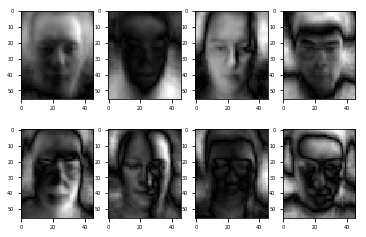

In [51]:
# ---------eigen face as an example------------#
matplotlib.rcParams.update({'font.size': 5})
# for i in range(0,8):
#     temp = eigvecs[:,i]
#     img2plt = np.reshape(temp,(46,56)).T
#     plt.subplot(2, 4, i+1)
#     plt.imshow(img2plt.real, cmap = 'gist_gray')

eigvecs_abs=np.abs(eigvecs)
for i in range(0,8):
    temp = eigvecs_abs[:,i]
    img2plt = np.reshape(temp,(46,56)).T
    plt.subplot(2, 4, i+1)
    plt.imshow(img2plt.real, cmap = 'gist_gray')

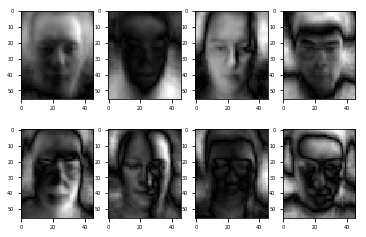

In [53]:
# ---------visualise eigenvector relationship------------#
for i in range(0,8):
    temp = np.matmul(img_norm,eigvecs_low[:,i])
    temp = np.abs(temp)
    img2plt = np.reshape(temp,(46,56)).T
    plt.subplot(2, 4, i+1)
    plt.imshow(img2plt.real, cmap = 'gist_gray')

In [ ]:
eigvecs = np.real(eigvecs)
eigvals = np.real(eigvals)
reconstruction
original face benchmark
img_train_bm = img_train[:,157]
img_train_bm = np.reshape(img_train_bm,(46,56))
img_train_bm = img_train_bm.T
plt.subplot(1, 2, 1)
plt.imshow(img_train_bm, cmap = 'gist_gray')

---------reconstruciton as an example------------#
using first M eigenvectors
M = 100
face_proj = np.matmul(img_norm[:,157].T, eigvecs[:,:M])
#projections
face157_proj = face_proj.T
face157_recon = np.zeros((2576,1)).T
#reconstruction
for i in range(M):
    face157_recon = np.add(face_proj[i] * eigvecs[:,i], face157_recon)
    
face157_recon = face157_recon + img_mean
face_157_recon = np.reshape(face157_recon ,(46,56)).T
plt.subplot(1, 2, 2)
plt.imshow(face_157_recon, cmap = 'gist_gray')

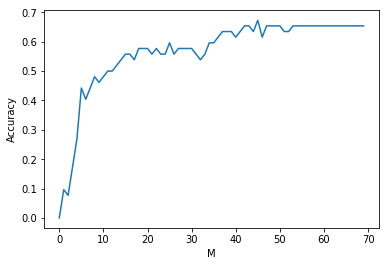

In [38]:
# ------------------recognition-----------------------
M_dim = 70
acc_plot=np.zeros((M_dim,1))
# for M in range(1,251):
for M in range(1,M_dim+1):
    
    w_n = np.matmul(img_norm.T, eigvecs[:,:M]) # w_n is img_train.shape[1]*M
    # project onto eigenspace
    w = np.matmul(img_norm_test.T, eigvecs[:,:M]) # w is img_test.shape[1]*20
    e_NN = np.zeros((img_train.shape[1],1))
    count = 0
    for i in range(img_test.shape[1]):          
        for j in range(img_train.shape[1]):
            e_NN[j]=np.linalg.norm(w[i,:]-w_n[j,:])
        #plt.plot(e_val)
        idx_val=np.argmin(e_NN) # the index in train set as per img_train.shape[1] train images
        id_pred=int(img_idx_train[idx_val]/10)+1 # predicted label
        id_true=int(img_idx_test[i]/10)+1 # ground truth label
        if id_pred == id_true:
            count+=1
         # print("Number of data correctly recognised: " count)
        accuracy=count/img_test.shape[1]
        acc_plot[M-1]=accuracy    
plt.plot(acc_plot)
plt.xlabel('M')
plt.ylabel('Accuracy')
plt.show()

It is seen that the accuracy saturates as M approaches around 70.

Text(0,0.5,'eigenvals and low-dim eigenvals')

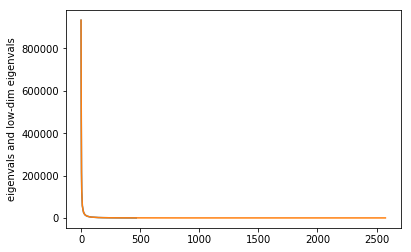

In [39]:
# low-diemensional computation of eigenspace
# S= np.cov(img_train, bias=True)
# eigvals, eigvecs = np.linalg.eig(S)

# eigvecs_low = np.real(eigvecs_low) # if we previously did the conversion, here we also do
# plt.plot(eigvals_low)
# plt.ylabel('low-dim eigenvals')
# plt.show()
# plt.plot(eigvals)
# plt.ylabel('eigenvals')
# plt.show()
plt.plot(eigvals_low)
plt.plot(eigvals)
plt.ylabel('eigenvals and low-dim eigenvals')

# plt.show()
# print(eigvals.shape)
# print(eigvals_low.shape)
# print(np.linalg.norm(eigvals[:468]-eigvals_low))
# print(eigvals[:468]-eigvals_low)
# print(eigvals[:468].shape)

The norm of the discrepany between two eigenvalues are 2.6149e-9 indicating that the eigenvalues are the same.

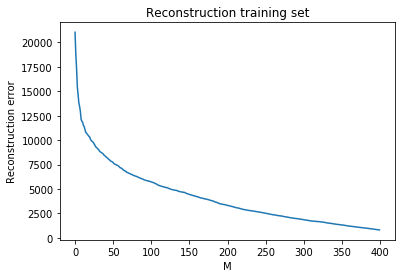

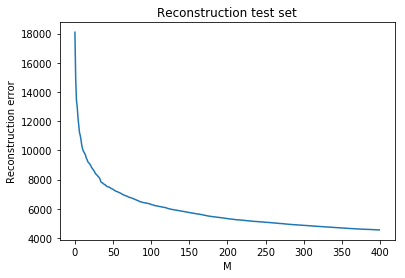

In [40]:
eigvecs_pseudo = np.matmul(img_norm,eigvecs_low) # u is 2576 * 468 real
# Normalise computed u to 1
eigvecs_pseudo = preprocessing.normalize(eigvecs_pseudo, norm='l2', axis=0) # axis = 0, normalise each feature
# u_norm = np.real(u_norm) # if eigvecs previously forced to real, we also force real here to allow comparison

# use first M eigenvectors for reconstruction
# M = 400
# # i = 150
# acc = 0
# error_recon = np.zeros(M)
# for k in range(0,M): # enumerate M principal components
#     w=np.matmul(img_norm.T, eigvecs[:,:M]) # w_n consists of M eigen coefficients
#     w=w.T
#     sum_train = np.zeros((num_pix, img_train.shape[1]))
#     for i in range(img_train.shape[1]): #enumerate all training faces
#         for j in range(k):
#             sum_train[:,i]=np.add(w[j,i]*eigvecs[:,j],sum_train[:,i])
#         error = img_norm[:,i] - sum_train[:,i] 
#         error = np.linalg.norm(error)
#         temp = np.linalg.norm(error)
#         acc = acc + temp
#     error_recon[k] = acc
#     acc = 0
    
# error_recon.sort()
# error_recon = error_recon[::-1]

# ------------------reconstruction error temporarily plot only 10 faces--------------------- #
M = 400
n_pics = 10
acc = 0
error_recon = np.zeros(M)
for k in range(0,M): # enumerate M principal components
    w=np.matmul(img_norm.T, eigvecs[:,:M]) # w_n consists of M eigen coefficients
    w=w.T
    sum_train = np.zeros((num_pix, n_pics))
    for i in range(n_pics): #enumerate all training faces
        for j in range(k):
            sum_train[:,i]=np.add(w[j,i]*eigvecs[:,j],sum_train[:,i])
        error = img_norm[:,i] - sum_train[:,i] 
        error = np.linalg.norm(error)
        temp = np.linalg.norm(error)
        acc = acc + temp
    error_recon[k] = acc
    acc = 0
    
error_recon.sort()
error_recon = error_recon[::-1]
    
# plot 3 reconstructed images
# plt.subplot(1,3,1)
# plt.imshow(np.reshape(sum_train[:,157],(46,56)).T, cmap = 'gist_gray')
# plt.subplot(1,3,2)
# plt.imshow(np.reshape(sum_train[:,257],(46,56)).T, cmap = 'gist_gray')
# plt.subplot(1,3,3)
# plt.imshow(np.reshape(sum_train[:,357],(46,56)).T, cmap = 'gist_gray')

plt.plot(error_recon)
plt.xlabel('M')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction training set')
plt.show()

# ------------------test set reconstruction error--------------------- #
M = 400
n_pics = 10
acc = 0
error_recon = np.zeros(M)
for k in range(0,M): # enumerate M principal components
    w=np.matmul(img_norm_test.T, eigvecs[:,:M]) # w_n consists of M eigen coefficients
    w=w.T
    sum_test = np.zeros((num_pix, n_pics))
    for i in range(n_pics): #enumerate all training faces
        for j in range(k):
            sum_test[:,i]=np.add(w[j,i]*eigvecs[:,j],sum_test[:,i])
        error = img_norm_test[:,i] - sum_test[:,i] 
        error = np.linalg.norm(error)
        temp = np.linalg.norm(error)
        acc = acc + temp
    error_recon[k] = acc
    acc = 0
    
error_recon.sort()
error_recon = error_recon[::-1]

plt.plot(error_recon)
plt.xlabel('M')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction test set')
plt.show()

In [41]:
cnf_matrix = np.zeros((img_test.shape[1],img_test.shape[1]))
y_true = np.zeros(52)
y_pred = np.zeros(52)

# ------------------recognition-----------------------
M = 70    
w_n = np.matmul(img_norm.T, eigvecs[:,:M]) # w_n is img_train.shape[1]*M
# project onto eigenspace
w = np.matmul(img_norm_test.T, eigvecs[:,:M]) # w is img_test.shape[1]*20
e_NN = np.zeros((img_train.shape[1],1))
count = 0
for i in range(img_test.shape[1]):          
    for j in range(img_train.shape[1]):
        e_NN[j]=np.linalg.norm(w[i,:]-w_n[j,:])
    #plt.plot(e_val)
    idx_val=np.argmin(e_NN) # the index in train set as per img_train.shape[1] train images
    id_pred=int(img_idx_train[idx_val]/10)+1 # predicted label
    id_true=int(img_idx_test[i]/10)+1 # ground truth label
    y_true[i] = id_true
    y_pred[i] = id_pred
    if id_pred == id_true:
        cnf_matrix[id_pred-1,id_true-1]+=1
        count+=1
    else:
        cnf_matrix[id_pred-1,id_true-1]+=1
     # print("Number of data correctly recognised: " count)
#         accuracy=count/img_test.shape[1]
#         acc_plot[M-1]=accuracy    
# plt.plot(acc_plot)
# plt.xlabel('M')
# plt.ylabel('Accuracy')
# plt.show()
# cnf_matrix.astype(int)
# class_names = list(range(1, img_test.shape[1]+1))
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='NN confusion matrix')
# plt.show()


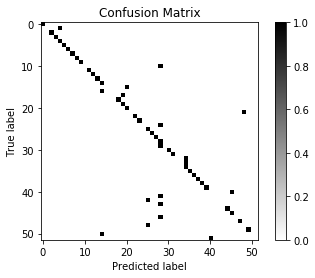

In [42]:
labels = list(set(y_true))
#use sklearn
conf_mat = confusion_matrix(y_true, y_pred, labels = labels)
#two types of confusion matrix, one is run once, another is record 52 test faces
plot_confusion_matrix(conf_mat)

In [ ]:
print(labels)